In [1]:
#Imports for CCD
from osgeo import gdal
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date
import numpy as np
%matplotlib inline
import ccd

#import ccd.classification as cls


In [2]:
pixel_x =95  #6       # 931 
pixel_y =2 #802 #803   #534
#parent_dir='/Users/arthur.platel/Desktop/Fusion_Images/Imperial_Subset'
#parent_dir = '/Users/arthur.platel/Desktop/Fusion_Images/CZU_FireV2'
#parent_dir='/Users/arthur.platel/Desktop/Fusion_Images/SantaCruz_NoFire'
#parent_dir='/Users/arthur.platel/Desktop/Fusion_Images/CZU_FireV2'
#parent_dir='/Users/arthur.platel/Desktop/Fusion_Images/hospital/PF-SR'
#parent_dir='/Users/arthur.platel/Desktop/Fusion_Images/deforestationV2/PF-SR'
parent_dir='/Users/arthur.platel/Desktop/Fusion_Images/Red_river/PF-SR'

In [3]:
from ccd import data_input

#import data from images
data = data_input.get_data(parent_dir,pixel_x,pixel_y,True)
dates, blues, greens, reds, nirs, ndvis, ndwis, qas = data

params = {'QA_BITPACKED': False,
              'QA_FILL': 255,
              'QA_CLEAR': 0,
              'QA_WATER': 1,
              'QA_SHADOW': 2,
              'QA_SNOW': 3,
              'QA_CLOUD': 4}


In [4]:
#calculate results using ccd
results = ccd.detect(dates, blues, greens, reds, nirs, ndvis, ndwis, qas, params)
#print("pixel {} has {}".format((pixel_x,pixel_y),results['change_models']))


In [5]:
#classifier=cls.createClassifier()
for seq in results["change_models"]:
    #lc=cls.classify(cls.toDF(seq),classifier)
    #seq['landclass']=lc
    print(seq)
  



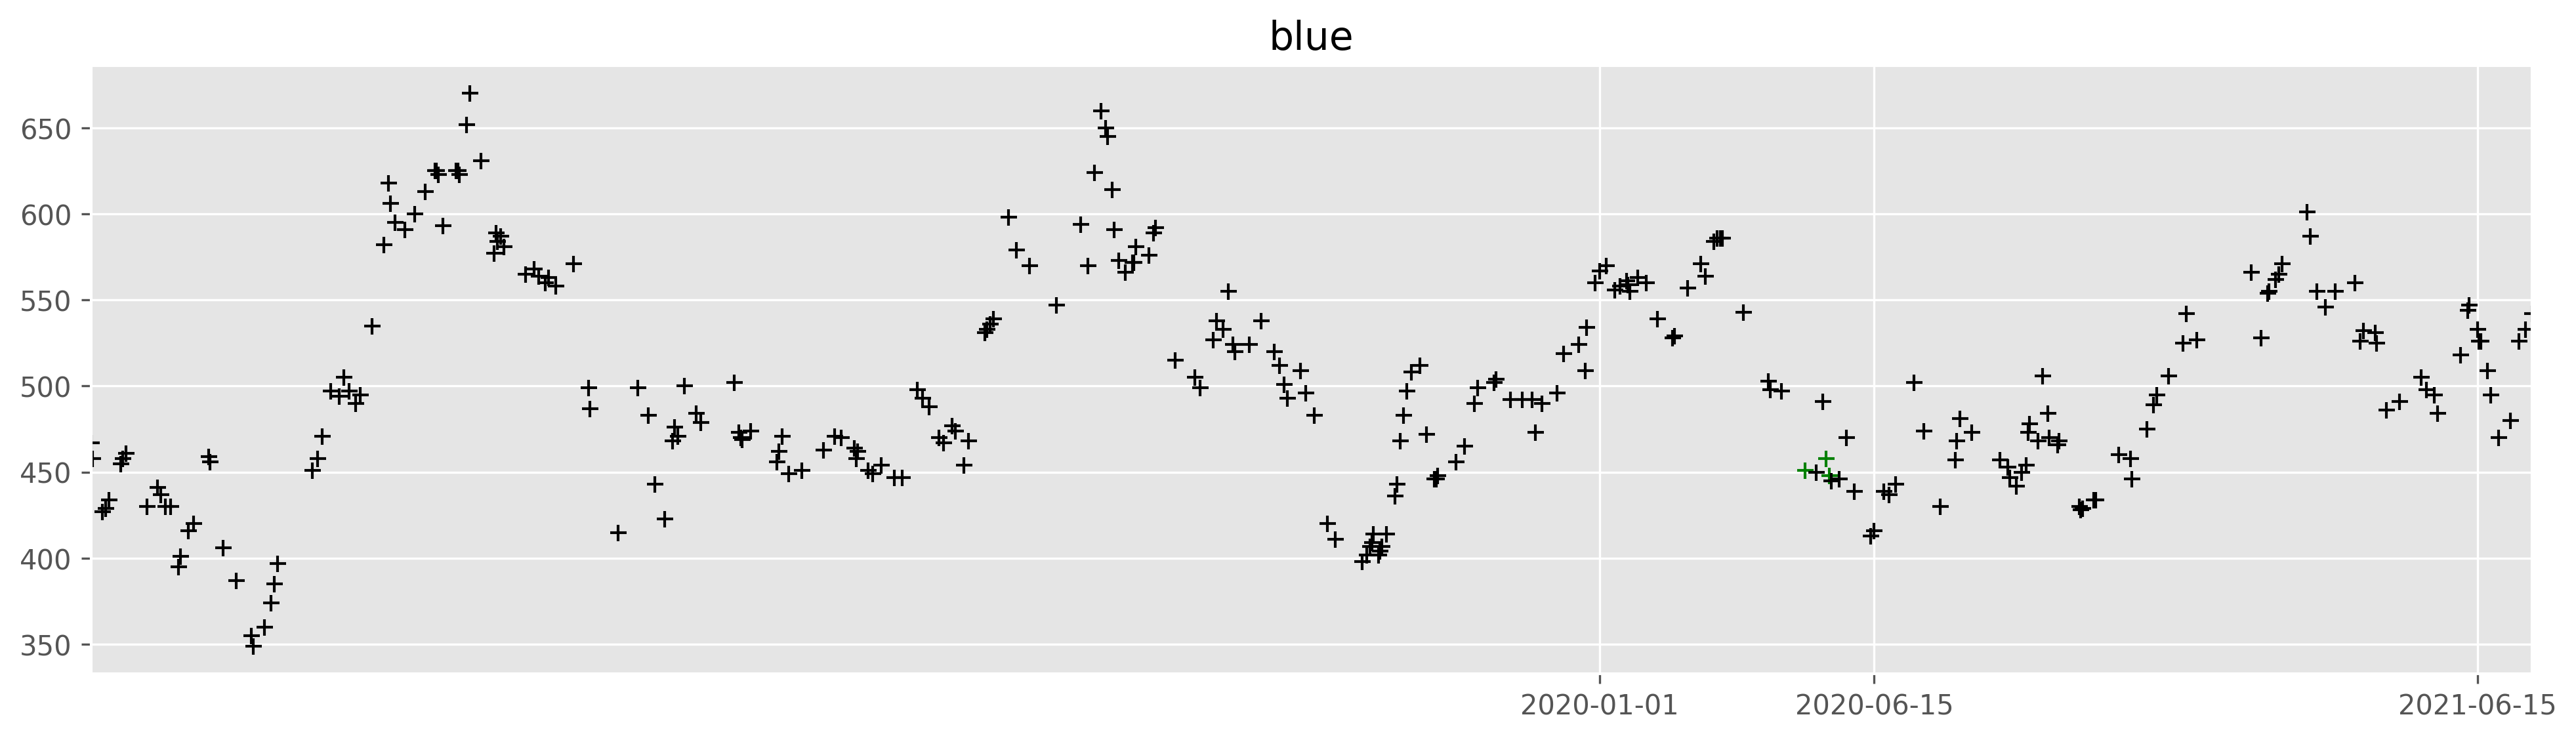

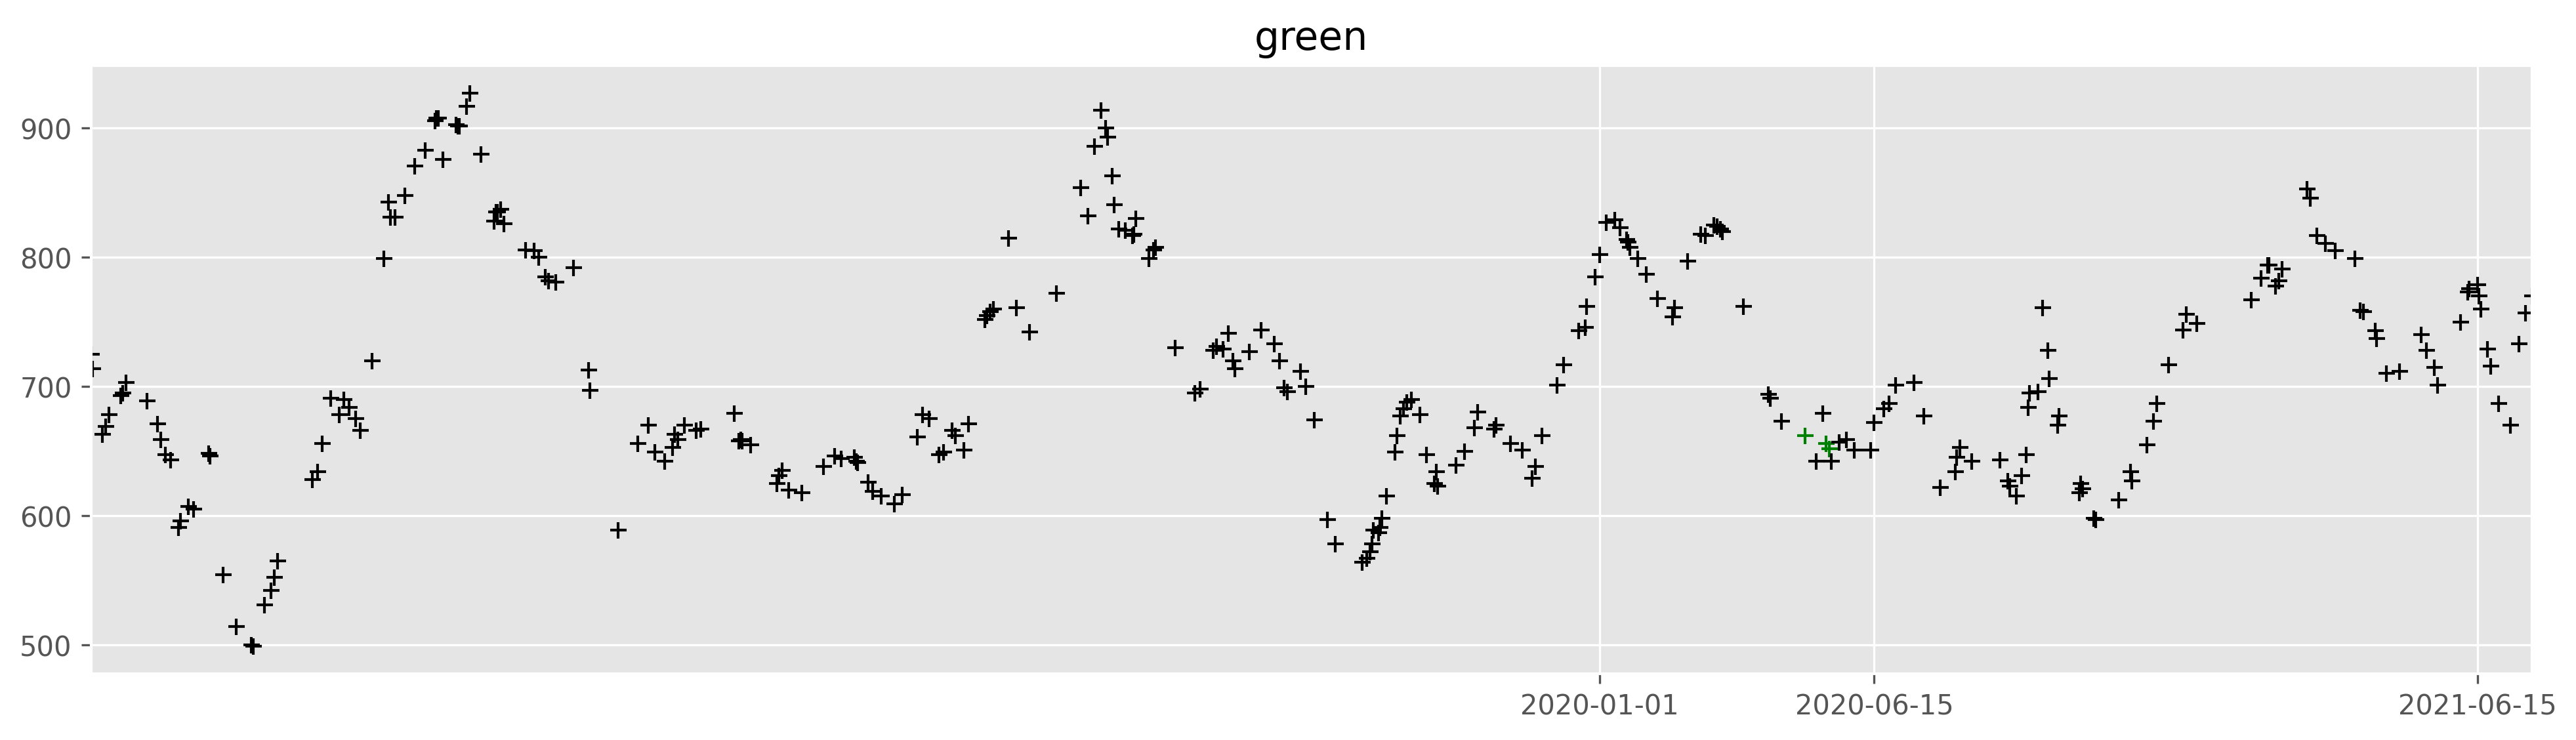

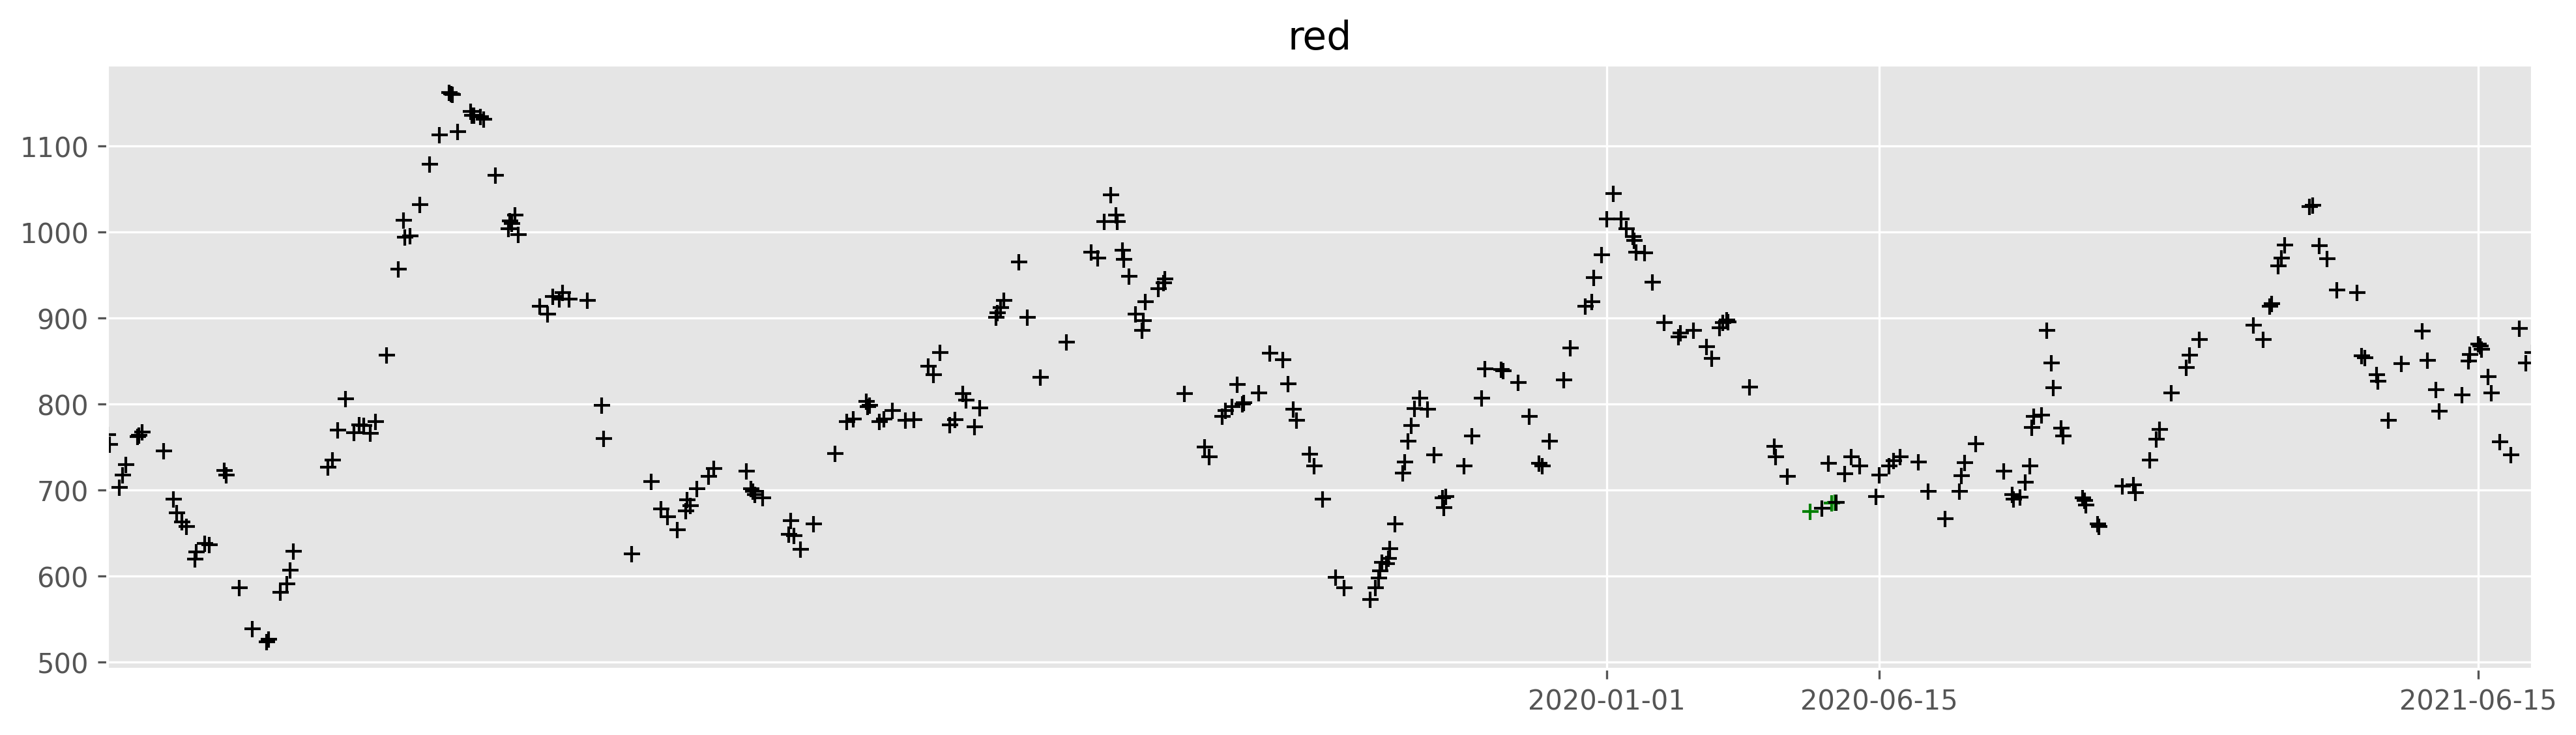

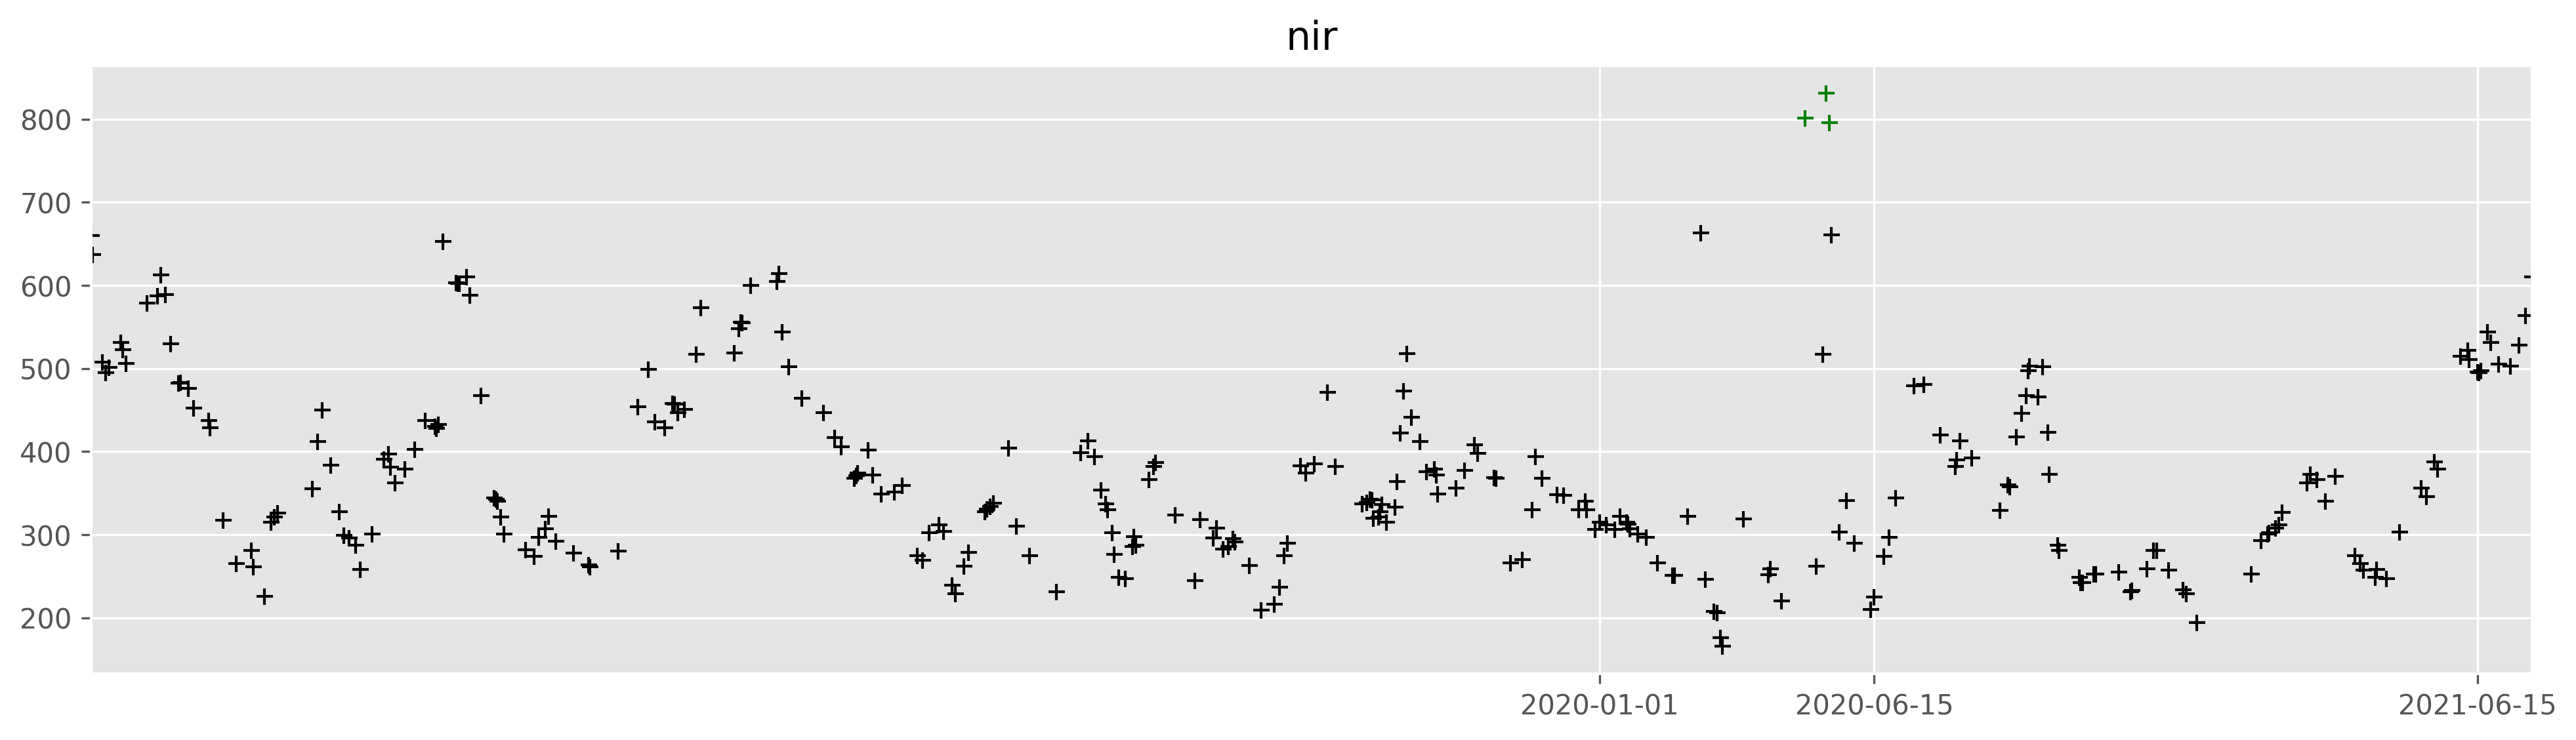

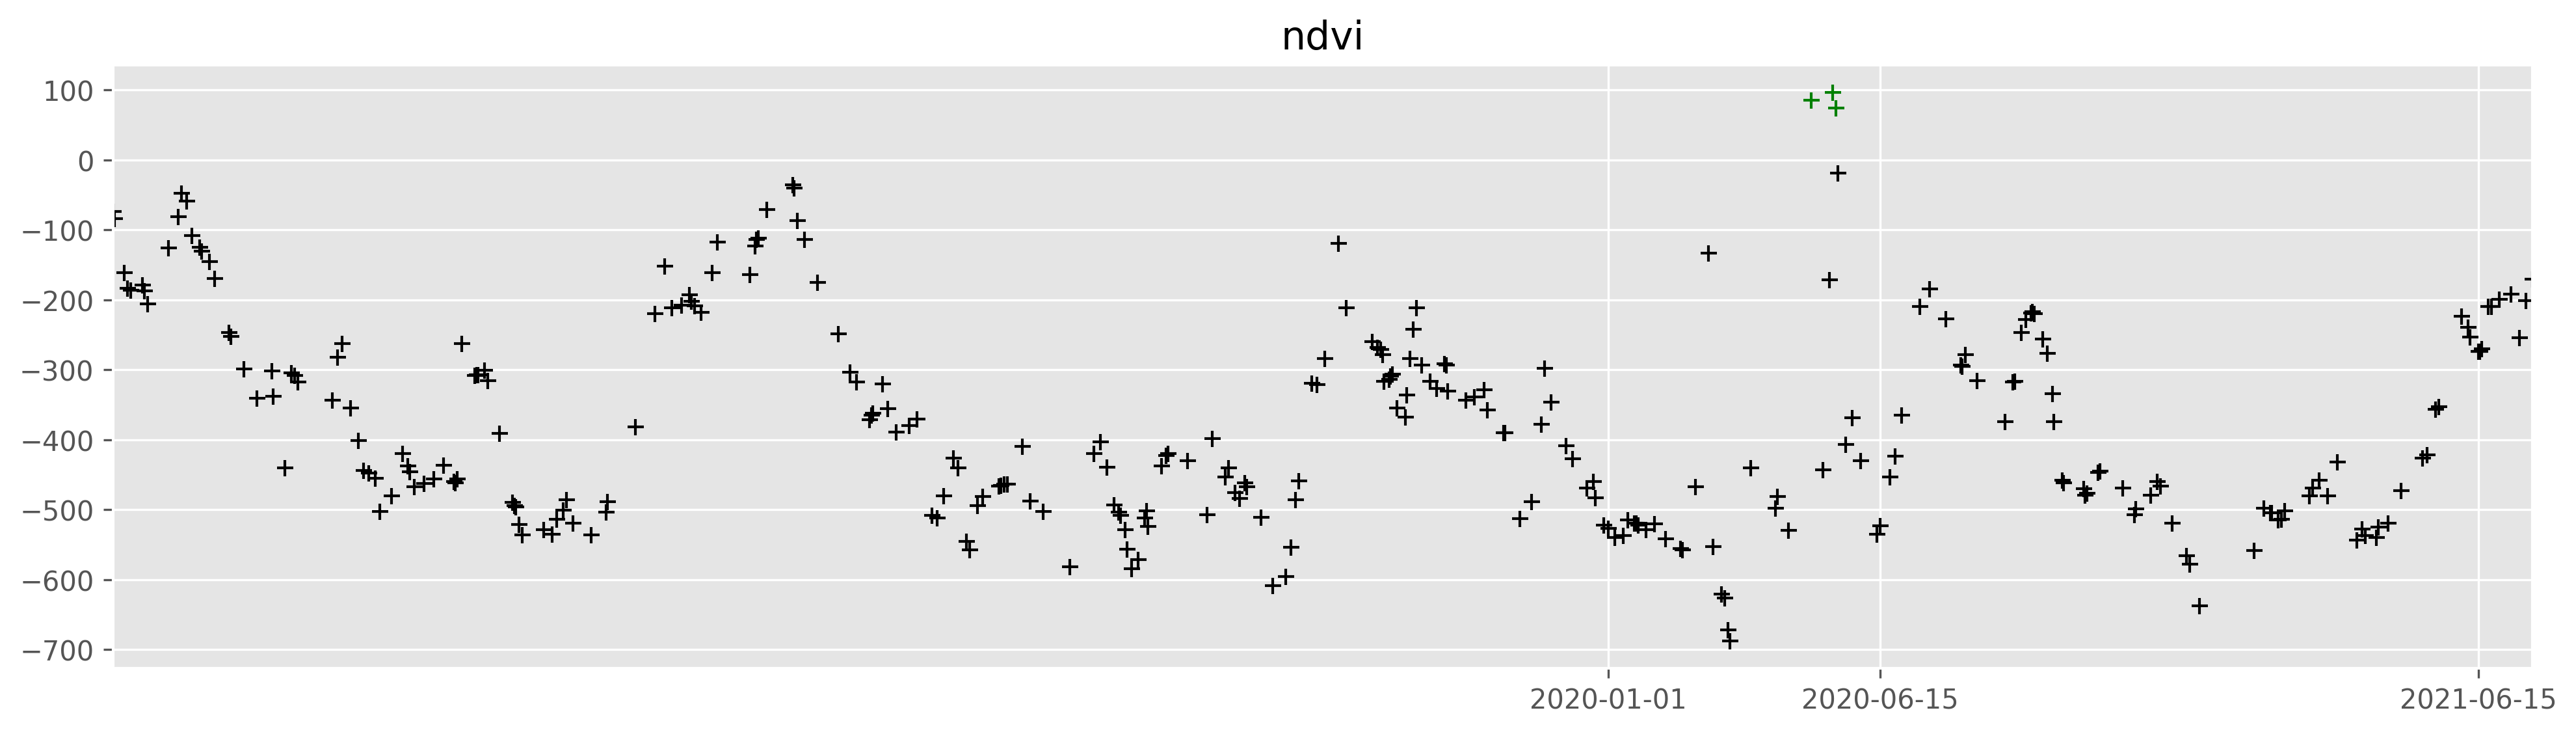

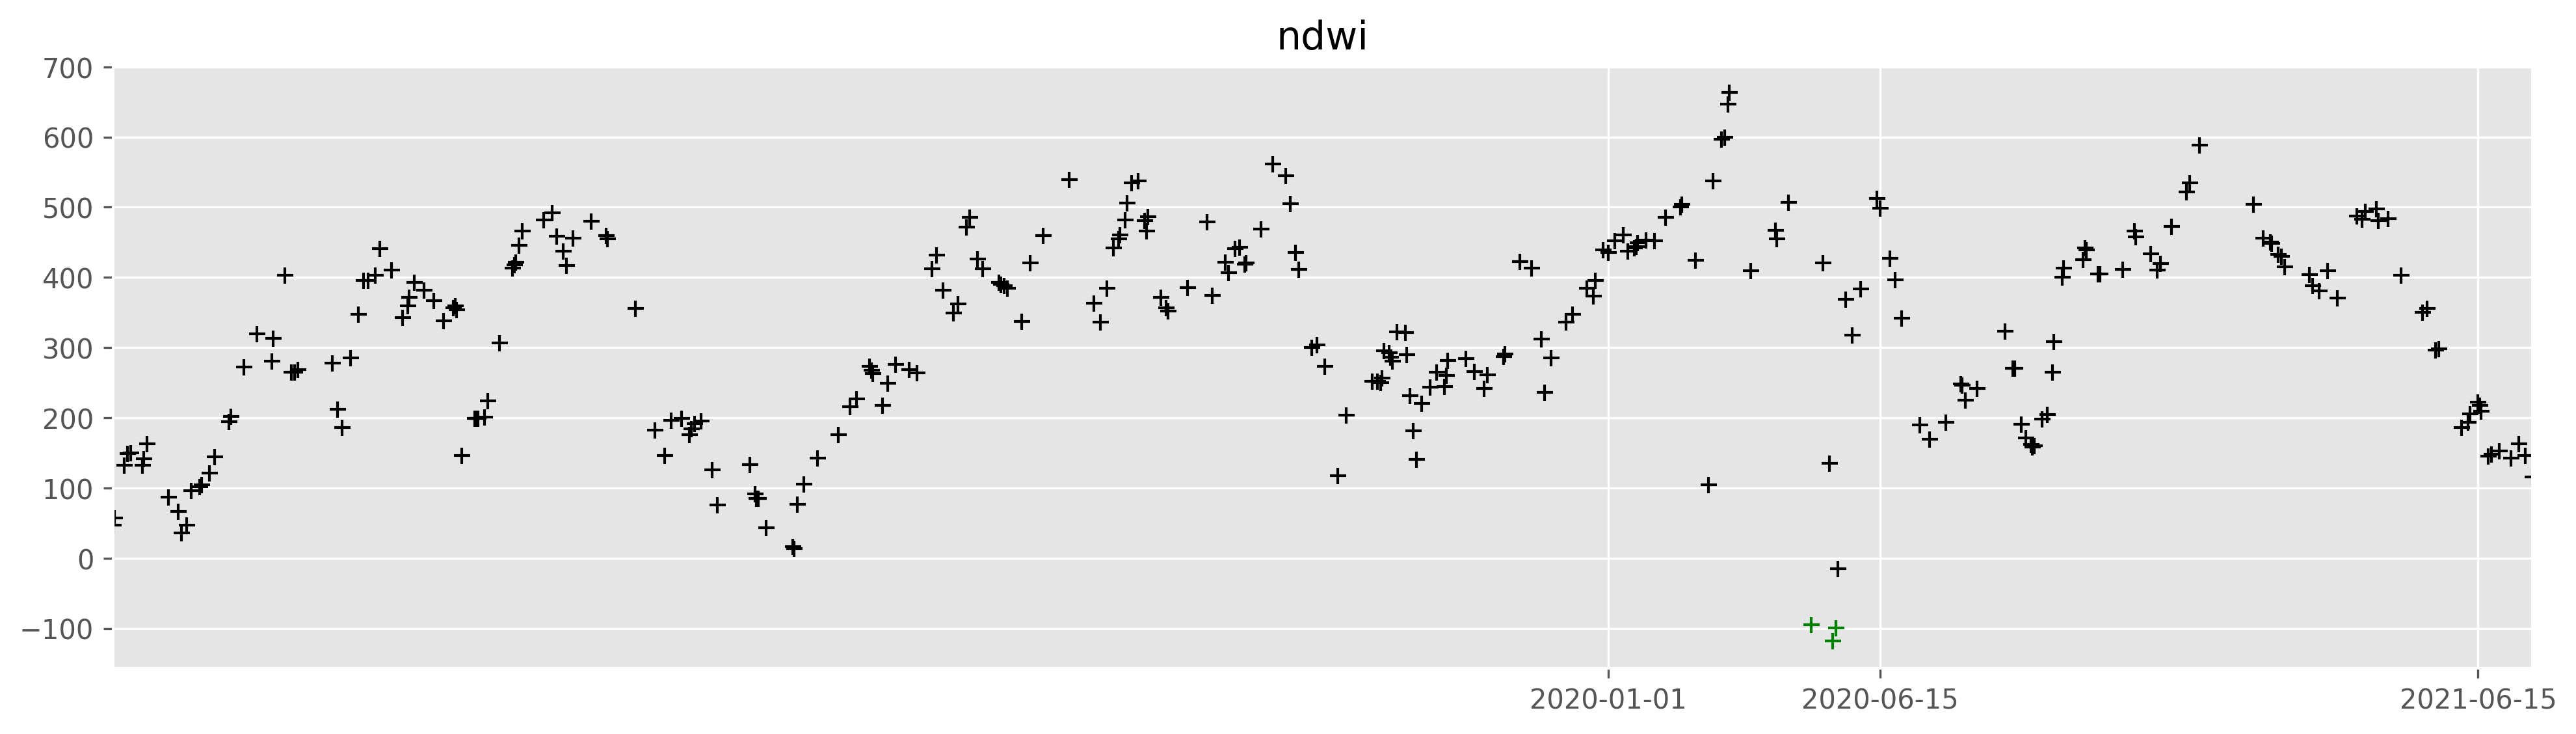

In [6]:
#Plot Results
def plot(band,bands,results,dates):
    predicted_values = []
    prediction_dates = []
    break_dates = []
    start_dates = []
    mask = np.array(results['processing_mask'], dtype=bool)
    new_dates=[]
    dates2=[]
    for k in dates:
        if (date.fromordinal(int(k)).day==15 and date.fromordinal(int(k)).month)==6 or (date.fromordinal(int(k)).day==1 and date.fromordinal(int(k)).month==1) :
            dates2.append(k)
            new_dates.append(str(date.fromordinal(int(k))))

    for num, result in enumerate(results['change_models']):
        days = np.arange(result['start_day'], result['end_day'] + 1)
        prediction_dates.append(days)
        break_dates.append(result['break_day'])
        start_dates.append(result['start_day'])
        
        intercept = result[band]['intercept']
        coef = result[band]['coefficients']
        
        predicted_values.append(intercept + coef[0] * days +
                                coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
                                coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
                                coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))
        
    plt.style.use('ggplot')
    fg = plt.figure(figsize=(16,9), dpi=300)
    #Removed y-axis value, but can standardize later
    if band=='ndvi':
        a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)) )   
    elif band=='nir':
        a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)))
    else:
        a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)))

    for _preddate, _predvalue in zip(prediction_dates, predicted_values):
        a1.plot(_preddate, _predvalue, 'orange', linewidth=1)

    # fg = plt.figure(figsize=(16,9), dpi=300)
    # a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates), ylim=(-5000, 5000))

    # Predicted curves
    for _preddate, _predvalue in zip(prediction_dates, predicted_values):
        a1.plot(_preddate, _predvalue, 'orange', linewidth=2)

    a1.plot(dates[mask], bands[mask], 'g+') # Observed values
    a1.plot(dates[~mask], bands[~mask], 'k+') # Observed values masked out
    for s in start_dates: a1.axvline(s, color='b')
    for b in break_dates: a1.axvline(b, color='r')
    plt.title(band)
    plt.xticks(ticks=dates2,labels=new_dates)
    return a1

    
bands = ["blue","green","red","nir","ndvi",'ndwi']
for k in range(len(bands)):
    plot(bands[k],data[k+1],results,dates)


In [7]:
#'end_day': 737821, 'break_day': 737832,
# from scipy.stats import mode
# for idx in range(dates.shape[0]):
#         var = dates[1 + idx:] - dates[:-idx - 1]
#         #print(mode(var)[0][0])
#         diff = data[:, 1 + idx:] - data[:, :-idx - 1]
#         print(diff)